In [21]:
# reference: https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue

import pandas as pd
import json


dir='/Users/xinwang/ai/dataset/kaggle/GStore/'

def load_df(filename, nrows=None):
    JSON_COLUMNS = ['device','geoNetwork','totals','trafficSource']
    
    df = pd.read_csv(dir+filename, converters = {column: json.loads for column in JSON_COLUMNS},
                    dtype={'fullVisitorId':'str'},
                    nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = pd.io.json.json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        print('load col', column)
        
    print(f"Loaded" ,filename," shape", df.shape, df.columns)
    
    return df

train_df = load_df('train.csv')
test_df = load_df('test.csv')

load col device
load col geoNetwork
load col totals
load col trafficSource
Loaded train.csv  shape (903653, 55) Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', '

In [22]:
train_df.T.head(100)

,0,1,2,3,4,5,6,7,8,9,...,903643,903644,903645,903646,903647,903648,903649,903650,903651,903652
channelGrouping,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,...,Social,Social,Social,Social,Social,Social,Social,Social,Social,Social
date,20160902,20160902,20160902,20160902,20160902,20160902,20160902,20160902,20160902,20160902,...,20170104,20170104,20170104,20170104,20170104,20170104,20170104,20170104,20170104,20170104
fullVisitorId,1131660440785968503,377306020877927890,3895546263509774583,4763447161404445595,27294437909732085,2938943183656635653,1905672039242460897,537222803633850821,4445454811831400414,9499785259412240342,...,056144239667131330,256641390199759052,2035095632074835075,567297396362985009,2140149974339316233,5123779100307500332,7231728964973959842,5744576632396406899,2709355455991750775,0814900163617805053
sessionId,1131660440785968503_1472830385,377306020877927890_1472880147,3895546263509774583_1472865386,4763447161404445595_1472881213,27294437909732085_1472822600,2938943183656635653_1472807194,1905672039242460897_1472817241,537222803633850821_1472812602,4445454811831400414_1472805784,9499785259412240342_1472812272,...,056144239667131330_1483600246,256641390199759052_1483556333,2035095632074835075_1483570454,567297396362985009_1483581760,2140149974339316233_1483557808,5123779100307500332_1483554750,7231728964973959842_1483543798,5744576632396406899_1483526434,2709355455991750775_1483592857,0814900163617805053_1483574474
socialEngagementType,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,...,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
visitId,1472830385,1472880147,1472865386,1472881213,1472822600,1472807194,1472817241,1472812602,1472805784,1472812272,...,1483600246,1483556333,1483570454,1483581760,1483557808,1483554750,1483543798,1483526434,1483592857,1483574474
visitNumber,1,1,1,1,2,1,1,1,1,1,...,4,1,1,1,1,1,1,1,1,1
visitStartTime,1472830385,1472880147,1472865386,1472881213,1472822600,1472807194,1472817241,1472812602,1472805784,1472812272,...,1483600246,1483556333,1483570454,1483581760,1483557808,1483554750,1483543798,1483526434,1483592864,1483574474
device.browser,Chrome,Firefox,Chrome,UC Browser,Chrome,Chrome,Chrome,Chrome,Internet Explorer,Firefox,...,Chrome,Chrome,Safari (in-app),Chrome,Chrome,Chrome,Chrome,Android Webview,Chrome,Chrome
device.browserSize,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset


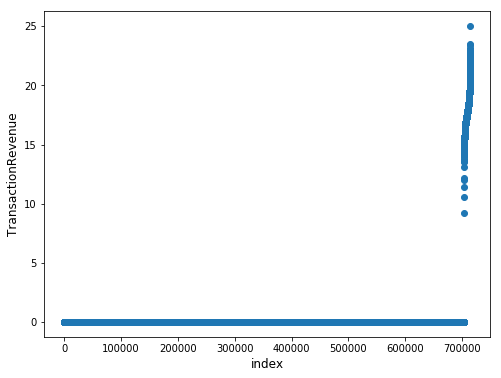

In [23]:
import matplotlib.pyplot as plt
import numpy as np

train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype('float')

gdf = train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf['totals.transactionRevenue'].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [24]:
nzi = pd.notnull(train_df['totals.transactionRevenue']).sum()
nzr = (gdf['totals.transactionRevenue']>0).sum()

print(nzi,train_df.shape[0],100*(nzi/train_df.shape[0]))
print(nzr,gdf.shape[0],100*(nzi/gdf.shape[0]))

11515 903653 1.27427231470487
9996 714167 1.6123679755575375


In [25]:
print(train_df.fullVisitorId.nunique(), train_df.shape[0])
print(test_df.fullVisitorId.nunique(), test_df.shape[0])

print(len(
    set(train_df.fullVisitorId.unique())
    .intersection(
        set(test_df.fullVisitorId.unique()))))


714167 903653
617242 804684
7679


In [26]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1]
print('constant columns',const_cols)

train_df.drop(columns=const_cols, inplace=True)
test_df.drop(columns=const_cols, inplace=True)


constant columns ['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters']


In [29]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf


def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(x=cnt_srs.values[::-1],
                  y=cnt_srs.index[::-1],
                  showlegend=False,
                  orientation='h',
                  marker=dict(color=color))
    return trace

## Browser
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count',ascending=False)

trace1 = horizontal_bar_chart(cnt_srs['count'].head(1000), 'rgb(50,171,96,0.6)')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(1000),'rgb(50,171,96,0.6)')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(1000),'rgb(50,171,96,0.6)')



## Device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count',ascending=False)
trace4 = horizontal_bar_chart(cnt_srs['count'].head(1000), 'rgb(71,58,131,0.8)')
trace5 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(1000), 'rgb(71,58,131,0.8)')
trace6 = horizontal_bar_chart(cnt_srs['mean'].head(1000), 'rgb(71,58,131,0.8)')


# device.operatingSystem
cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace7 = horizontal_bar_chart(cnt_srs['count'].head(1000), 'rgb(81,68,131,0.8)')
trace8 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(1000), 'rgb(81,68,131,0.8)')
trace9 = horizontal_bar_chart(cnt_srs['mean'].head(1000), 'rgb(81,68,131,0.8)')


fig = plotly.tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04,
                         subplot_titles=['Browser -count','Browser -non-zero revenue count','Browser -revenue mean',
                                        'deviceCategory -count','deviceCategory -non-zero revenue count','deviceCategory -mean'
                                        ])
fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,2)
fig.append_trace(trace3,1,3)

fig.append_trace(trace4,2,1)
fig.append_trace(trace5,2,2)
fig.append_trace(trace6,2,3)

fig.append_trace(trace7,3,1)
fig.append_trace(trace8,3,2)
fig.append_trace(trace9,3,3)


fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title='Device plots')
py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



PlotlyRequestError: Account limit reached: Your account is limited to creating 25 charts. To continue, you can override or delete existing charts or you can upgrade your account at: https://plot.ly/products/cloud

In [30]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(x=cnt_srs.index[::-1],
                      y=cnt_srs.values[::-1],
                      showlegend=False,
                      marker=dict(color=color))
    return trace

train_df['date_str'] = train_df['date'].astype(str)
test_df['date_str'] = test_df['date'].astype(str)
train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]),
                                                                 int(str(x)[4:6]),
                                                                 int(str(x)[6:])))
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size','count'])
cnt_srs.columns = ['count','count of non-zero revenue']

cnt_srs = cnt_srs.sort_index()

trace1 = scatter_plot(cnt_srs['count'],'red')
trace2 = scatter_plot(cnt_srs['count of non-zero revenue'],'blue')

fig = plotly.tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                                subplot_titles=['Date -count','Date -non-zero revenue count'])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
    
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title='Date plots')
py.iplot(fig, filename='Date plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [31]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), 
                                                                int(str(x)[4:6]), 
                                                                int(str(x)[6:])))

cnt_srs = test_df.groupby('date')['fullVisitorId'].agg(['size'])

trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(height=400, width=800, paper_bgcolor='rgb(233,233,233)',title='Dates in Test set')

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Date In test file')

In [32]:
# geoNetwork.continent
cnt_srs = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace1 = horizontal_bar_chart(cnt_srs['count'].head(1000),'rgba(58,71,80,0.6)')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(1000),'rgba(58,71,80,0.6)')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(1000),'rgba(58,71,80,0.6)')


# geoNetwork.subContinent
cnt_srs = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace4 = horizontal_bar_chart(cnt_srs['count'].head(1000),'rgba(98,71,80,0.6)')
trace5 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(1000),'rgba(98,71,80,0.6)')
trace6 = horizontal_bar_chart(cnt_srs['mean'].head(1000),'rgba(98,71,80,0.6)')


# geoNetwork.networkDomain
cnt_srs = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace7 = horizontal_bar_chart(cnt_srs['count'].head(100),'rgba(128,71,80,0.6)')
trace8 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(100),'rgba(128,71,80,0.6)')
trace9 = horizontal_bar_chart(cnt_srs['mean'].head(100),'rgba(128,71,80,0.6)')


fig = plotly.tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.05,
                                subplot_titles=['continent count','continent non-zero count','continent mean revenue',
                                               'subContinent count','subContinent non-zero count','subContinent mean revenue',
                                               'networkDomain count','networkDomain non-zero count','networkDomain mean revenue'])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)

fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title='Geo plots')
py.iplot(fig, filename='geo plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [33]:
# trafficSource.source
cnt_srs = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace1 = horizontal_bar_chart(cnt_srs['count'].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(10), 'green')

# trafficSource.medium
cnt_srs = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace4 = horizontal_bar_chart(cnt_srs['count'].head(10), 'purple')
trace5 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(10), 'purple')
trace6 = horizontal_bar_chart(cnt_srs['mean'].head(10), 'purple')


fig = plotly.tools.make_subplots(rows=2, cols=3, vertical_spacing=0.07, horizontal_spacing=0.08,
                                subplot_titles=['trafficSource count','trafficSource non-zero count','trafficSource revenue mean',
                                               'trafficSource medium count','trafficSource medium non-zero count','trafficSource medium revenue mean'])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)

fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)


fig['layout'].update(height=1000,width=1200, paper_bgcolor='rgb(233,233,233)', title='Traffic Source plots')
py.iplot(fig, filename='trafficeSource plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [34]:
# totals.pageviews
cnt_srs = train_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace1 = horizontal_bar_chart(cnt_srs['count'].head(100), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(100), 'cyan')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(100), 'cyan')

# hits
cnt_srs = train_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count','count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)

trace4 = horizontal_bar_chart(cnt_srs['count'].head(60), 'blue')
trace5 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(60), 'blue')
trace6 = horizontal_bar_chart(cnt_srs['mean'].head(60), 'blue')

fig = plotly.tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.08,
                                subplot_titles=['pageviews count','pageviews non-zero revenue count','pageviews mean',
                                               'hits count','hits non-zero revenue count','hits mean'])


fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,2)
fig.append_trace(trace3,1,3)

fig.append_trace(trace4,2,1)
fig.append_trace(trace5,2,2)
fig.append_trace(trace6,2,3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title='Visitor profile plots')

py.iplot(fig, filename='visitor-profile-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [35]:
train_df.drop(columns=['trafficSource.campaignCode'], axis=1, inplace=True)
# test_df.drop(columns=['trafficSource.campaignCode'], axis=1, inplace=True)

print(train_df.columns.values)

['channelGrouping' 'date' 'fullVisitorId' 'sessionId' 'visitId'
 'visitNumber' 'visitStartTime' 'device.browser' 'device.deviceCategory'
 'device.isMobile' 'device.operatingSystem' 'geoNetwork.city'
 'geoNetwork.continent' 'geoNetwork.country' 'geoNetwork.metro'
 'geoNetwork.networkDomain' 'geoNetwork.region' 'geoNetwork.subContinent'
 'totals.bounces' 'totals.hits' 'totals.newVisits' 'totals.pageviews'
 'totals.transactionRevenue' 'trafficSource.adContent'
 'trafficSource.adwordsClickInfo.adNetworkType'
 'trafficSource.adwordsClickInfo.gclId'
 'trafficSource.adwordsClickInfo.isVideoAd'
 'trafficSource.adwordsClickInfo.page'
 'trafficSource.adwordsClickInfo.slot' 'trafficSource.campaign'
 'trafficSource.isTrueDirect' 'trafficSource.keyword'
 'trafficSource.medium' 'trafficSource.referralPath'
 'trafficSource.source' 'date_str']


In [36]:
from sklearn.preprocessing import LabelEncoder


train_df['totals.transactionRevenue'].fillna(0, inplace=True)

cate_columns = ['channelGrouping','device.browser','device.deviceCategory','device.operatingSystem',
                'geoNetwork.city','geoNetwork.continent','geoNetwork.country','geoNetwork.metro',
                'geoNetwork.networkDomain','geoNetwork.region','geoNetwork.subContinent',
                'trafficSource.adContent','trafficSource.adwordsClickInfo.adNetworkType',
                'trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.isVideoAd',
                'trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.slot',
                'trafficSource.campaign','trafficSource.isTrueDirect','trafficSource.keyword']


label = LabelEncoder()
def label_transform(df, col_list):
    for col in col_list:
        df[col] = label.fit_transform(df[col])

    return df

for col in cate_columns:
    print(col,' fit transform...')
    lbl = LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) +
           list(test_df[col].values.astype('str')))
    
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    

numeric_columns = ['totals.bounces','totals.hits','totals.newVisits','totals.pageviews','visitNumber',
                   'visitStartTime']
for col in numeric_columns:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)
    print('numeric column', col)


channelGrouping  fit transform...
device.browser  fit transform...
device.deviceCategory  fit transform...
device.operatingSystem  fit transform...
geoNetwork.city  fit transform...
geoNetwork.continent  fit transform...
geoNetwork.country  fit transform...
geoNetwork.metro  fit transform...
geoNetwork.networkDomain  fit transform...
geoNetwork.region  fit transform...
geoNetwork.subContinent  fit transform...
trafficSource.adContent  fit transform...
trafficSource.adwordsClickInfo.adNetworkType  fit transform...
trafficSource.adwordsClickInfo.gclId  fit transform...
trafficSource.adwordsClickInfo.isVideoAd  fit transform...
trafficSource.adwordsClickInfo.page  fit transform...
trafficSource.adwordsClickInfo.slot  fit transform...
trafficSource.campaign  fit transform...
trafficSource.isTrueDirect  fit transform...
trafficSource.keyword  fit transform...
numeric column totals.bounces
numeric column totals.hits
numeric column totals.newVisits
numeric column totals.pageviews
numeric colu

In [39]:
print(cate_columns)

['channelGrouping', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'year', 'month', 'day', 'week', 'weekofyear', 'dayofweek', 'quarter', 'month_start', 'month_end']


In [38]:
##################datetime##################
date_cate_features = ['year','month','day','week','weekofyear','dayofweek','quarter','month_start','month_end']

def process_datetime(df):
    df['datetime'] = pd.to_datetime(df['date_str'], format='%Y%m%d',errors='ignore')
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['month'] =df['month'].astype(int)
    
    df['day'] = df['datetime'].dt.day
    df['day'] = df['day'].astype(int)

    df['week'] = df['datetime'].dt.week
    df['week'] = df['week'].astype(int)
    
    df['weekofyear'] = df['datetime'].dt.weekofyear
    df['weekofyear'] = df['weekofyear'].astype(int)
    
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['dayofweek'] = df['dayofweek'].astype(int)
    
    df['quarter'] = df['datetime'].dt.quarter
    df['quarter'] = df['quarter'].astype(int)
    
    df['month_start'] = df['day'].apply(lambda x: 1 if x<=7 else 0).astype(int)
    df['month_end'] = df['day'].apply(lambda x: 1 if x>=25 else 0).astype(int)

    df = label_transform(df, date_cate_features)
    
    return df

train_df = process_datetime(train_df)
test_df = process_datetime(test_df)
cate_columns += date_cate_features

print('process_datetime done')

###################################### 
last_time_features = ['last_seconds','last_minutes']

def process_last_time(df):
    df['last_seconds'] = df['visitStartTime']-df['visitId']
    df['last_minutes'] = (df['visitStartTime']-df['visitId'])/60
    df['last_minutes'] = df['last_minutes'].astype(np.int64)

    return df

train_df = process_last_time(train_df)
test_df = process_last_time(test_df)
numeric_columns += last_time_features
print('process_last_time done')

process_datetime done
process_last_time done


In [40]:
day_seconds = 24 * 60* 60
month_seconds = 30 * day_seconds
debug=False

transaction_features = ['days_from_last_visted','months_from_last_visted','max_visit_number',
                        'sum_previous_pageviews','sum_previous_hits','transaction_count']
numeric_columns += transaction_features


#################### Parallel run  #################### 
import tqdm

#CreateFeature the seconds from last visited
def create_feature_times_from_last_visited(group_df):
    days_from_last_array = []
    months_from_last_array = []
    
    visitId_array = group_df['visitId'].values
    last = visitId_array[0]
    for item in group_df['visitId'].values:
        days = int((item-last)/day_seconds)
        days_from_last_array.append(days)
        
        months = int((item-last)/month_seconds)
        months_from_last_array.append(months)
        
        last = item
        
        
    group_df['days_from_last_visted'] = days_from_last_array
    group_df['months_from_last_visted'] = months_from_last_array
    
    return group_df
    
def create_feature_max_visit_number(group_df):
    max_visit_num = np.max(group_df['visitNumber'])
    
    group_df['max_visit_number'] = [max_visit_num]*group_df.shape[0]
    
    return group_df

def create_feature_previous_sum_pageviews(group_df):
    sum_previous_pageviews = []
    sum = 0
    for item in group_df['totals.pageviews'].values:
        sum += item
        sum_previous_pageviews.append(sum)
            
    group_df['sum_previous_pageviews'] = sum_previous_pageviews
    
    return group_df
    
def create_feature_previous_sum_hits(group_df):
    sum_previous_hits = []
    sum = 0
    for item in group_df['totals.hits'].values:
        sum += item
        sum_previous_hits.append(sum)
            
    group_df['sum_previous_hits'] = sum_previous_hits
    
    return group_df
    
def create_feature_transaction_count(group_df):
    count = group_df.shape[0]
    
    group_df['transaction_count'] = [count] * group_df.shape[0]
    
    return group_df


import multiprocessing

def process_one_group(group_df):
    group_df = create_feature_times_from_last_visited(group_df)
    group_df = create_feature_max_visit_number(group_df)
    
#   pageviews
    group_df = create_feature_previous_sum_pageviews(group_df)
#   hits
    group_df = create_feature_previous_sum_hits(group_df)
#   transcation count
    group_df = create_feature_transaction_count(group_df)

    return group_df
    

def parallel_batch_process_groups(grouped):
    print('Run parallel_batch_process_groups')
    
    batch = []
    first_batch=True
    result_df = pd.DataFrame()

    counter = 0
    total = len(grouped.size())
    for name, group_df in grouped:
        group_df_copy = group_df.copy()
        
        fullVisitorId = group_df_copy['fullVisitorId'].values[0]

        group_df_copy.sort_values(by='visitNumber', inplace=True)
        group_df_copy = process_one_group(group_df_copy)

        batch.append(group_df_copy)
        counter += 1
        del group_df_copy
        
        if len(batch)>=5000:
            print('progress report', multiprocessing.current_process().name,100.0*(counter/total))
            if first_batch is True:
                result_df = pd.concat(batch, axis=0)
                del batch
                batch = []
                first_batch = False
            else:
                batch_df = pd.concat(batch, axis=0)
                result_df = pd.concat([result_df, batch_df], axis=0)
                del batch
                del batch_df
                batch = []
        
    batch_df = pd.concat(batch, axis=0)
    
    if result_df.shape[0]>0:
        result_df = pd.concat([result_df, batch_df], axis=0)
    else:
        result_df = batch_df
    del batch
    del batch_df
            
    return result_df
    

def applyParallelInBatch(df, by_field, func):
    df_copy = df.copy()
    
    batch_size=8
    
    df_copy['hash_index'] = df_copy[by_field].apply(lambda x: hash(x) % batch_size)
    
    pool = multiprocessing.Pool(processes=batch_size)
    
    batch_result = []
    for i in range(batch_size):
        batch_df = df_copy[df_copy['hash_index'] == i]
        grouped = batch_df.groupby(by_field)
        
        batch_result.append(pool.apply_async(func, args=(grouped,)))
        print('apply async job to pool',batch_df.shape)
        
    print()
    print()
    pool.close()
    pool.join()
    
    result_df = pd.DataFrame(columns=df.columns)
    for i in batch_result:
        part_df = i.get()
        result_df = pd.concat([result_df,part_df], axis=0)
        print('got result result_df',result_df.shape)
            
    return result_df


def process_transactions(df):
    print('Parallel run applyParallelInBatch')
    input_columns = ['fullVisitorId','visitId','visitNumber','totals.pageviews','totals.hits']
    transaction_df = applyParallelInBatch(df[['sessionId'] + input_columns ],
                                          'fullVisitorId',
                                          parallel_batch_process_groups)
    transaction_df.drop(input_columns, axis=1, inplace=True)

    print('should have', len(df['fullVisitorId'].unique()))
    print('transaction_df.shape',transaction_df.shape)

    df = pd.merge(df,transaction_df, on='sessionId', how='left')

    del transaction_df
    
    return df
    
train_df = process_transactions(train_df)
test_df = process_transactions(test_df)

print('process_transactions done')
print('train.shape',train_df.shape)
print('test.shape',test_df.shape)

Parallel run applyParallelInBatch
apply async job to pool (113259, 7)
apply async job to pool (113332, 7)
apply async job to pool Run parallel_batch_process_groups
Run parallel_batch_process_groups
(113282, 7)
apply async job to pool (112192, 7)
apply async job to pool (112514, 7)
apply async job to pool (113583, 7)
Run parallel_batch_process_groups
apply async job to pool (112257, 7)
apply async job to pool (113234, 7)


Run parallel_batch_process_groups
Run parallel_batch_process_groups
Run parallel_batch_process_groups
Run parallel_batch_process_groups
Run parallel_batch_process_groups
progress report ForkPoolWorker-27 5.576311827357386
progress report ForkPoolWorker-26 5.605255487545122
progress report ForkPoolWorker-25 5.598351845216768
progress report ForkPoolWorker-28 5.635898418566904
progress report ForkPoolWorker-29 5.605821084614263
progress report ForkPoolWorker-31 5.605381165919283
progress report ForkPoolWorker-30 5.585344057193923
progress report ForkPoolWorker-32 5.5954

/Users/xinwang/ai/lib/python3.6/site-packages/ipykernel_launcher.py:160: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




got result result_df (113259, 13)
got result result_df (226591, 13)
got result result_df (339873, 13)
got result result_df (452065, 13)
got result result_df (564579, 13)
got result result_df (678162, 13)
got result result_df (790419, 13)
got result result_df (903653, 13)
should have 714167
transaction_df.shape (903653, 8)
Parallel run applyParallelInBatch
Run parallel_batch_process_groups
apply async job to pool (100381, 7)
apply async job to pool (100640, 7)
apply async job to pool (99951, 7)
Run parallel_batch_process_groups
apply async job to pool (100570, 7)
apply async job to pool (101086, 7)
apply async job to pool (100789, 7)
apply async job to pool (100259, 7)
Run parallel_batch_process_groups
Run parallel_batch_process_groups
apply async job to pool (101008, 7)


Run parallel_batch_process_groups
Run parallel_batch_process_groups
Run parallel_batch_process_groups
Run parallel_batch_process_groups
progress report ForkPoolWorker-34 6.458946933291997
progress report ForkPoolWorke

In [47]:
print('cate_columns len', len(cate_columns))
print()
print('numeric_columns len',len(numeric_columns))

cate_columns len 29

numeric_columns len 14


In [44]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from math import sqrt

    
def train_and_split(seed=1234):
    train_df_copy = train_df.copy()
    dev_df = train_df_copy.sample(frac=0.8, random_state=seed)
    val_df = train_df_copy.drop(dev_df.index)
    
    print(dev_df.shape,val_df.shape,train_df_copy.shape)

    dev_y = np.log1p(dev_df['totals.transactionRevenue'].values)
    val_y = np.log1p(val_df['totals.transactionRevenue'].values)


    dev_x = dev_df[cate_columns + numeric_columns]
    val_x = val_df[cate_columns + numeric_columns]
    
    return dev_x, val_x, dev_y, val_y

def rmse(y_actual, y_predict):
    return sqrt(mean_squared_error(y_actual, y_predict))
    

xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.8, eval_metric='rmse',
                       max_depth=5,colsample_bytree=0.8, silent=False, seed=1234)

def train_and_valid(epochs = 5):
    array = []
    for i in range(epochs):
        dev_x, val_x, dev_y, val_y = train_and_split(seed=i*100 +1)

        model = xgb.fit(dev_x, dev_y)
        predict = model.predict(val_x)

        metric_value = rmse(val_y,predict)
        print('xgb ',i,' predict metric rmse', metric_value)
        array.append(metric_value)
        
    print('final mean rmse', np.mean(array))
    return model
    
model = cv_rmse = train_and_valid(1)

(724359, 55) (181090, 55) (905449, 55)
xgb  0  predict metric rmse 1.7398460988065498
final mean rmse 1.7398460988065498


In [49]:
print(test_df.shape)
print(len(test_df['fullVisitorId'].values))

(806326, 54)
806326


In [50]:
test_x = test_df[cate_columns + numeric_columns]
predict_test = model.predict(test_x)

print('test_x.shape',test_x.shape,'predict_test len', len(predict_test))

sub_df = pd.DataFrame({'fullVisitorId':test_df['fullVisitorId'].values})
predict_test[predict_test<0] = 0 
print('sub_df.shape',sub_df.shape)

sub_df['PredictedLogRevenue'] = np.expm1(predict_test)

sub_df = sub_df.groupby('fullVisitorId')['PredictedLogRevenue'].sum().reset_index()
sub_df.columns = ['fullVisitorId','PredictedLogRevenue']

sub_df['PredictedLogRevenue'] = np.log1p(sub_df['PredictedLogRevenue'])

sub_df.to_csv('xgb_base.csv', index=False)

print('predict done')

test_x.shape (806326, 43) predict_test len 806326
sub_df.shape (806326, 1)
predict done
